In [358]:
import torch, pickle, librosa
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

## Import Data

In [2]:
file = open('data-200-29.pkl', 'rb')
df = pickle.load(file)
file.close()

In [3]:
df.head()

,subject,day,session,motion,repetition,window_emg
0,sub03,D3,S1,OH,1,"[[0.4140625, 0.6015625, -0.203125, -0.2109375,..."
1,sub03,D3,S1,OH,1,"[[-0.453125, 0.109375, -0.234375, -0.078125, -..."
2,sub03,D3,S1,OH,1,"[[-0.046875, 0.0390625, -0.4296875, -0.0546875..."
3,sub03,D3,S1,OH,1,"[[0.15625, 0.015625, -0.2265625, -0.0234375, 0..."
4,sub03,D3,S1,OH,1,"[[-0.1484375, -0.140625, 0.015625, 0.03125, 0...."


In [4]:
df.shape

(2891700, 6)

## Preprocessing Data

### Change Labels into Numerics

In [300]:
df['label'] = df.motion.replace(
    df.motion.drop_duplicates().tolist(),
    [i for i in range(9)]
)

/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_22139/4281264563.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df.motion.replace(


In [301]:
df.head()

,subject,day,session,motion,repetition,window_emg,label
0,sub03,D3,S1,OH,1,"[[0.4140625, 0.6015625, -0.203125, -0.2109375,...",0
1,sub03,D3,S1,OH,1,"[[-0.453125, 0.109375, -0.234375, -0.078125, -...",0
2,sub03,D3,S1,OH,1,"[[-0.046875, 0.0390625, -0.4296875, -0.0546875...",0
3,sub03,D3,S1,OH,1,"[[0.15625, 0.015625, -0.2265625, -0.0234375, 0...",0
4,sub03,D3,S1,OH,1,"[[-0.1484375, -0.140625, 0.015625, 0.03125, 0....",0


### Explore Spectrograms

In [12]:
fs = 200

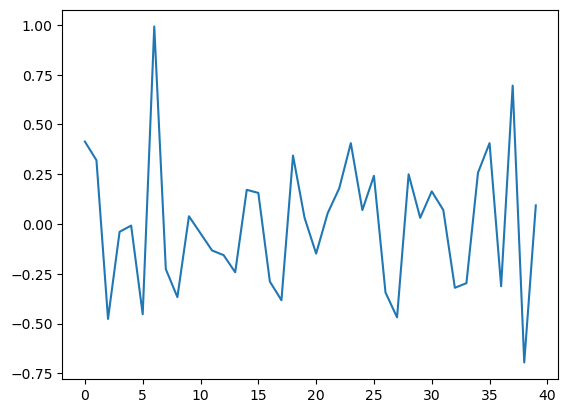

In [11]:
plt.plot(df.loc[0].window_emg[:,0]);

In [223]:
freqs = np.fft.rfftfreq(40, 1/fs)

In [224]:
fft = np.fft.rfft(df.loc[0].window_emg[:,0])

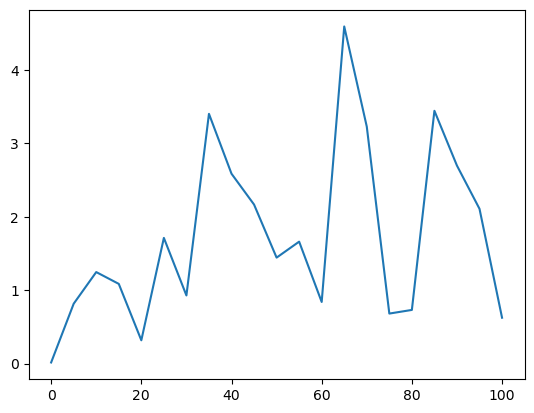

In [226]:
plt.plot(freqs, np.abs(fft))

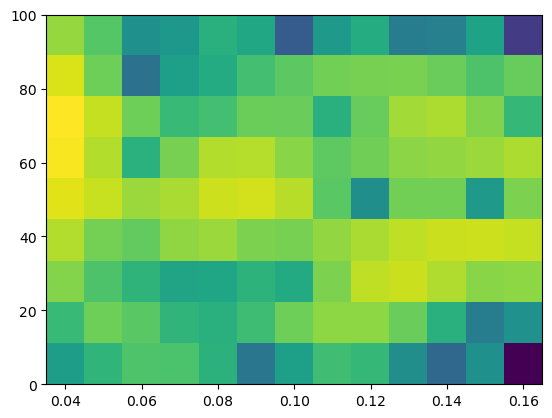

In [26]:
spec, freq, _, _ = plt.specgram(df.loc[0].window_emg[:,0], Fs=fs, NFFT=16, noverlap=14)

In [57]:
mel_scale = lambda f: 2959 * np.log10(1 + f / 700)

In [272]:
def emg_to_lms(emg, fs=200, n_fft=128, hop_length=3):
    lms_list = list()
    
    for i in range(8):
        mel_spec = librosa.feature.melspectrogram(y=emg[:, i], sr=fs, n_fft=n_fft, hop_length=hop_length)
        lms = librosa.power_to_db(mel_spec)
        lms_list.append(lms)

    com_lms = np.hstack(lms_list)
    
    return com_lms

In [273]:
emg_to_lms(df.loc[0].window_emg)

array([[-68.24979786, -68.24979786, -68.24979786, ..., -71.33538676,
        -71.33538676, -71.33538676],
       [-15.63632691, -15.48703615, -15.3922437 , ...,   0.92776395,
          0.1050113 ,  -0.84843509],
       [-33.62973236, -33.48044159, -33.38564915, ..., -17.06564149,
        -17.88839415, -18.84184054],
       ...,
       [-14.93115607, -14.38235895, -13.8729068 , ..., -19.16062279,
        -19.71190312, -20.37202423],
       [  3.06224937,   3.61104649,   4.12049865, ...,  -1.16721735,
         -1.71849768,  -2.37861879],
       [-68.24979786, -68.24979786, -68.24979786, ..., -71.33538676,
        -71.33538676, -71.33538676]])

(128, 112)


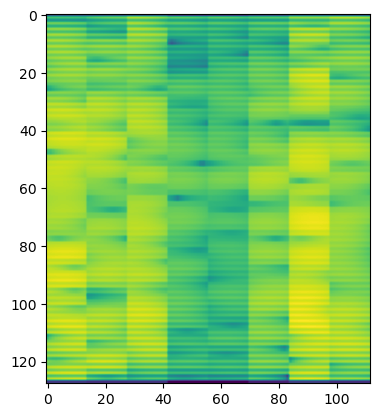

In [267]:
plt.imshow(emg_to_lms(df.loc[0].window_emg))

In [210]:
com_lms = np.hstack(lms_list)

In [175]:
resized_lms = librosa.util.fix_length(com_lms, size=128, axis=1)

## Building Model Architecture

In [385]:
class e2cnn(nn.Module):
    def __init__(self, input_width, input_height, num_classes):
        super(e2cnn, self).__init__()
        
        # Rescaling Layer
        self.rescale = lambda x: (x - x.min()) / (x.max() - x.min())

        # Feature Block A
        self.feature_block_a = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Feature Block B
        self.conv1b = nn.Conv2d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1b = nn.BatchNorm2d(16)
        self.pool1b = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2b = nn.Conv2d(17, 32, kernel_size=5, stride=1, padding=2) # 16 from L1b & 1 from RL1
        self.bn2b = nn.BatchNorm2d(32)
        self.pool2b = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3b = nn.Conv2d(50, 64, kernel_size=3, stride=1, padding=1) # 32 from L2b & 1 from RL1 & 17 from concat1
        self.bn3b = nn.BatchNorm2d(64)
        self.pool3b = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Classification Block
        self.flat_n = int(196 * (input_width / 8) * (input_height / 8))
        self.fc1 = nn.Linear(self.flat_n, 12)
        self.fc2 = nn.Linear(12, 12)
        self.fc3 = nn.Linear(12, num_classes)

    def forward(self, x):
        # Rescaling Layer
        x = self.rescale(x)
        rl_concat1 = F.max_pool2d(x, kernel_size=2, stride=2) # dim 1
        rl_concat2 = F.max_pool2d(x, kernel_size=4, stride=4) # dim 1
        rl_concat3 = F.max_pool2d(x, kernel_size=8, stride=8) # dim 1

        # Feature block A
        l3a = self.feature_block_a(x) # dim 64

        # Feature block B
        l1b = self.pool1b(F.relu(self.bn1b(self.conv1b(x)))) # dim 16
        concat1 = torch.cat((l1b, rl_concat1), dim=1) # dim 17
        concat1max = F.max_pool2d(concat1, kernel_size=2, stride=2) # dim 17
        concat1max_2 = F.max_pool2d(concat1, kernel_size=4, stride=4) # dim 17

        l2b = self.pool2b(F.relu(self.bn2b(self.conv2b(concat1)))) # dim 32
        concat2 = torch.cat((l2b, rl_concat2, concat1max), dim=1) # dim 50
        concat2max = F.max_pool2d(concat2, kernel_size=2, stride=2) # dim 50

        l3b = self.pool3b(F.relu(self.bn3b(self.conv3b(concat2)))) # dim 64
        concat3 = torch.cat((l3b, rl_concat3, concat2max, concat1max_2), dim=1) # dim 132

        # Classification Block
        concat4 = torch.cat((concat3, l3a), dim=1) # dim 196
        concat4 = concat4.reshape(-1, self.flat_n)
        out = self.fc3(F.relu(self.fc2(F.relu(self.fc1(concat4)))))
        
        return F.softmax(out, dim=1)
        

In [386]:
model = e2cnn(112, 128, 9)

In [338]:
model

e2cnn(
  (feature_block_a): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv1b): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (bn1b): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

## Training

### Cold-Run Training on Subject 1

#### Grab Subset of the Data

In [302]:
sub1 = df[(df.subject == 'sub01') & 
          (df.day.apply(lambda x: x in ('D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7'))) &
          (df.repetition.apply(lambda x: x in range(6)))].reset_index(drop=True)

In [305]:
sub1.label.value_counts()

label
0    10710
1    10710
2    10710
3    10710
4    10710
5    10710
6    10710
7    10710
8    10710
Name: count, dtype: int64

In [277]:
tqdm.pandas()

In [307]:
sub1['lms'] = sub1.window_emg.progress_apply(emg_to_lms)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 96390/96390 [12:52<00:00, 124.73it/s]


In [308]:
file = open('sub1-spec.pkl', 'wb')
pickle.dump(sub1, file)
file.close()

#### Cold-Run Forward Inference

In [387]:
sub1_ex = torch.FloatTensor(sub1.loc[0].lms).to('mps').unsqueeze(0).unsqueeze(0)
model.to('mps')
a = model(sub1_ex)

In [388]:
a

tensor([[0.0892, 0.1512, 0.0848, 0.1350, 0.1302, 0.1095, 0.0944, 0.0845, 0.1212]],
       device='mps:0', grad_fn=<SoftmaxBackward0>)

In [356]:
_, y_pred = a.max(1)

In [357]:
y_pred

tensor([4], device='mps:0')

In [243]:
torch.cat((torch.rand(1, 5, 5), torch.rand(2, 5, 5), torch.rand(3, 5,5 )), dim=0).shape

torch.Size([6, 5, 5])

#### Prepare Training Data

In [361]:
device = 'mps'

In [375]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(sub1.lms.to_numpy()), sub1.label.to_numpy(), test_size=0.2, random_state=42)

In [378]:
X_train = X_train.reshape(-1, 1, 128, 112)
X_test = X_test.reshape(-1, 1, 128, 112)

In [381]:
X_train_tensor = torch.FloatTensor(X_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [400]:
# Training loop
# Create dataloaders
train_set = TensorDataset(X_train_tensor, y_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

# Initialize model
model = e2cnn(112, 128, 9).to(device)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    for idx, (batch_x, batch_y) in enumerate(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        loss_val = loss.item()
        total_loss += loss_val

        if idx % 100 == 0:
            print(f"Epoch [{epoch+1}/100], Batch {idx}, Loss: {loss_val:.4f}")

    print(f"Epoch [{epoch + 1}/100], Avg Loss: {(total_loss / len(train_loader)):.4f}")

Epoch [1/100], Batch 0, Loss: 2.2071
Epoch [1/100], Batch 100, Loss: 1.9708
Epoch [1/100], Batch 200, Loss: 1.8359
Epoch [1/100], Batch 300, Loss: 1.8226
Epoch [1/100], Batch 400, Loss: 1.9112
Epoch [1/100], Batch 500, Loss: 1.7350
Epoch [1/100], Batch 600, Loss: 1.8982
Epoch [1/100], Batch 700, Loss: 1.6689
Epoch [1/100], Batch 800, Loss: 1.8916
Epoch [1/100], Batch 900, Loss: 1.8485
Epoch [1/100], Batch 1000, Loss: 1.7716
Epoch [1/100], Batch 1100, Loss: 1.8270
Epoch [1/100], Batch 1200, Loss: 1.6919
Epoch [1/100], Batch 1300, Loss: 1.6172
Epoch [1/100], Batch 1400, Loss: 1.8223
Epoch [1/100], Batch 1500, Loss: 1.8650
Epoch [1/100], Batch 1600, Loss: 1.7905
Epoch [1/100], Batch 1700, Loss: 1.7454
Epoch [1/100], Batch 1800, Loss: 1.7359
Epoch [1/100], Batch 1900, Loss: 1.8536
Epoch [1/100], Batch 2000, Loss: 1.6879
Epoch [1/100], Batch 2100, Loss: 1.7738
Epoch [1/100], Batch 2200, Loss: 1.6431
Epoch [1/100], Batch 2300, Loss: 1.6936
Epoch [1/100], Batch 2400, Loss: 1.8299
Epoch [1/100